In [0]:
!pip install bpemb

     |████████████████████████████████| 1.0MB 5.2MB/s 


In [0]:
import numpy as np
import torchtext
from torchtext import data
from torchtext.datasets import WikiText2
from bpemb import BPEmb
from torchtext.vocab import Vectors
from tqdm import tqdm
import matplotlib.pyplot as plt

# 2. Preparing the Data

In [0]:
bpemb_en = BPEmb(lang="en", dim=300, vs=20000)

BPEmb fallback: en from vocab size 20000 to 200000
downloading https://nlp.h-its.org/bpemb/en/en.wiki.bpe.vs200000.model


100%|██████████| 3776868/3776868 [00:00<00:00, 3783022.86B/s]


downloading https://nlp.h-its.org/bpemb/en/en.wiki.bpe.vs200000.d300.w2v.bin.tar.gz


100%|██████████| 224330457/224330457 [00:09<00:00, 22534341.34B/s]
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
bpemb_en.emb.save_word2vec_format('bpe_emv.vec') 

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
vectors = Vectors(name='bpe_emv.vec', cache='./')

100%|█████████▉| 199546/200000 [00:18<00:00, 11169.63it/s]

In [0]:
TEXT = data.Field(lower=True, tokenize=bpemb_en.encode)
train, valid, test = WikiText2.splits(TEXT)

downloading wikitext-2-v1.zip



wikitext-2-v1.zip:   0%|          | 0.00/4.48M [00:00<?, ?B/s]
wikitext-2-v1.zip:   6%|▌         | 262k/4.48M [00:00<00:01, 2.38MB/s]
wikitext-2-v1.zip:  59%|█████▉    | 2.65M/4.48M [00:00<00:00, 3.24MB/s]
wikitext-2-v1.zip: 100%|██████████| 4.48M/4.48M [00:00<00:00, 18.7MB/s]

extracting


In [0]:
TEXT.build_vocab(train, vectors = vectors)

100%|█████████▉| 199546/200000 [00:30<00:00, 11169.63it/s]

In [0]:
train_iter, valid_iter, test_iter = data.BPTTIterator.splits(
    (train, valid, test),
    batch_size=32,
    bptt_len=30,
    device='cuda',
    repeat=False)

In [0]:
b = next(iter(train_iter))

In [0]:
vars(b).keys()

dict_keys(['batch_size', 'dataset', 'fields', 'text', 'target'])

In [0]:
b.text[:, :3]

tensor([[   14,    26,    46],
        [   16,    17,  4566],
        [ 3712,    47,     5],
        [ 3284, 14431,    81],
        [ 3731,   236,   138],
        [  852,   685,  4747],
        [   16,  3393,    36],
        [   14,    43, 26628],
        [   14,   919,    12],
        [13675,   316,   231],
        [18065,    15,    18],
        [   97,  5731,    67],
        [ 3712, 10336,  2671],
        [ 3284,     3,    61],
        [   27,    15,  7510],
        [   58,  9238,  1427],
        [    4,  8697,     6],
        [    7,  1188,  2143],
        [    9,    12,  4951],
        [    8,     2,    10],
        [ 3731,  2468,   207],
        [   32,     3,    62],
        [  753,   145,    77],
        [   58,    13,     4],
        [    4,  6634,     7],
        [28014,  8914,     9],
        [  293,  1449,     8],
        [    3,    17,  5734],
        [ 5232,     5, 19713],
        [    5,    34,    35]], device='cuda:0')

In [0]:
b.target[:, :3]

tensor([[   16,    17,  4566],
        [ 3712,    47,     5],
        [ 3284, 14431,    81],
        [ 3731,   236,   138],
        [  852,   685,  4747],
        [   16,  3393,    36],
        [   14,    43, 26628],
        [   14,   919,    12],
        [13675,   316,   231],
        [18065,    15,    18],
        [   97,  5731,    67],
        [ 3712, 10336,  2671],
        [ 3284,     3,    61],
        [   27,    15,  7510],
        [   58,  9238,  1427],
        [    4,  8697,     6],
        [    7,  1188,  2143],
        [    9,    12,  4951],
        [    8,     2,    10],
        [ 3731,  2468,   207],
        [   32,     3,    62],
        [  753,   145,    77],
        [   58,    13,     4],
        [    4,  6634,     7],
        [28014,  8914,     9],
        [  293,  1449,     8],
        [    3,    17,  5734],
        [ 5232,     5, 19713],
        [    5,    34,    35],
        [ 3712,    33,     2]], device='cuda:0')

# 3. Training the Language Model

In [0]:
USE_GPU = True

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable as V

In [0]:
class RNNModel(nn.Module):
    def __init__(self, ntoken, ninp, nhid, nlayers, bsz, dropout=0.5, tie_weights=True):
        super(RNNModel, self).__init__()
        self.nhid, self.nlayers, self.bsz = nhid, nlayers, bsz
        self.drop = nn.Dropout(dropout)
        self.encoder = nn.Embedding(ntoken, ninp)
        self.rnn = nn.LSTM(ninp, nhid, nlayers, dropout=dropout)
        self.decoder = nn.Linear(nhid, ntoken)
        self.init_weights()
        self.hidden = self.init_hidden(bsz) 

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.fill_(0)
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, input):
        emb = self.drop(self.encoder(input))
        output, self.hidden = self.rnn(emb, self.hidden)
        output = self.drop(output)
        decoded = self.decoder(output.view(output.size(0)*output.size(1), output.size(2)))
        return decoded.view(output.size(0), output.size(1), decoded.size(1))

    def init_hidden(self, bsz):
        weight = next(self.parameters()).data
        return (V(weight.new(self.nlayers, bsz, self.nhid).zero_().cuda()),
                V(weight.new(self.nlayers, bsz, self.nhid).zero_()).cuda())
    
    def reset_history(self):
        """Wraps hidden states in new Variables, to detach them from their history."""
        self.hidden = tuple(V(v.data) for v in self.hidden)

In [0]:
weight_matrix = TEXT.vocab.vectors

In [0]:
model = RNNModel(weight_matrix.shape[0], weight_matrix.shape[1], 300, 2, 32)

In [0]:
model.encoder.weight.data.copy_(weight_matrix);

In [0]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(model)

18282416

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, betas=(0.7, 0.99))

In [0]:
model = model.cuda()
criterion =criterion.cuda()

In [0]:
n_epochs = 5

In [0]:
n_tokens = weight_matrix.shape[0]

In [0]:
valid_loss = []
train_loss = []

def train_epoch(epoch, valid_loss, train_loss):
    """One epoch of a training loop"""
    
    model.train()

    progress_bar = tqdm(total=len(train_iter), disable=not True, desc='Train')

    for batch in train_iter:
      
        model.reset_history()
        
        optimizer.zero_grad()
        
        text, targets = batch.text, batch.target
        prediction = model(text)
    
        loss = criterion(prediction.view(-1, n_tokens), targets.view(-1))
        loss.backward()
        
        optimizer.step()
        l = loss.data.cpu().numpy()
        train_loss.append(l)
        progress_bar.set_postfix(loss=np.mean(train_loss[-150:]), perplexity=np.exp(np.mean(train_loss[-150:])))
        progress_bar.update()
        
   
    with torch.no_grad():
      val_loss = 0
      model.eval()
      for batch in valid_iter:
          model.reset_history()
          text, targets = batch.text, batch.target
          prediction = model(text)
          loss = criterion(prediction.view(-1, n_tokens), targets.view(-1))
          lv = loss.data.cpu().numpy()
          valid_loss.append(lv)
          val_loss += lv*text.shape[0]
          
      val_loss /= len(valid.examples[0].text)
    
    print('\nValidation Loss: {:.4f}'.format(val_loss)) 

In [0]:
for instance in list(tqdm._instances):
      tqdm._decr_instances(instance)

In [0]:
for epoch in range(1, n_epochs + 1):
    print('\nEpoch:{}'.format(epoch))
    train_epoch(epoch, valid_loss, train_loss)
    for instance in list(tqdm._instances):
      tqdm._decr_instances(instance)

Train:   0%|          | 0/2466 [00:00<?, ?it/s]


Epoch:1


Train:   0%|          | 0/2466 [00:00<?, ?it/s]


Validation Loss: 0.1431

Epoch:2


Train:   0%|          | 0/2466 [00:00<?, ?it/s]


Validation Loss: 0.1373

Epoch:3


Train:   0%|          | 0/2466 [00:00<?, ?it/s]


Validation Loss: 0.1342

Epoch:4


Train:   0%|          | 0/2466 [00:00<?, ?it/s]


Validation Loss: 0.1321

Epoch:5


Train: 100%|██████████| 2466/2466 [02:47<00:00, 14.69it/s, loss=4.93, perplexity=138]


Validation Loss: 0.1307


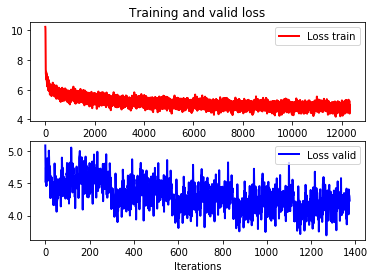

In [0]:
def loss_plot(train_loss, valid_loss ):
  plt.figure()
  plt.subplot(211)

  plt.title('Training and valid loss')
  plt.plot(train_loss, color='red', linewidth=2, label = 'Loss train')
  plt.legend()

  plt.subplot(212)
  plt.xlabel('Iterations')
  plt.plot(valid_loss, color='blue', linewidth=2, label = 'Loss valid')
  plt.legend()
  plt.show()

loss_plot(train_loss, valid_loss)

In [0]:
for instance in list(tqdm._instances):
    tqdm._decr_instances(instance)

In [0]:
b = next(iter(test_iter))

In [0]:
def word_ids_to_sentence(id_tensor, vocab,join=None):
    """Converts a sequence of word ids to a sentence"""
    if isinstance(id_tensor, torch.LongTensor):
        #print(id_tensor.shape)
        ids = id_tensor.transpose(0, 1).contiguous().view(-1)
        #print(ids.shape)
    elif isinstance(id_tensor, np.ndarray):
        ids = id_tensor.transpose().reshape(-1)

    batch = [vocab.itos[ind] for ind in ids]  # denumericalize
    if join is None:
        return batch
    else:
        return join.join(batch)

In [0]:
seed = b.text[:, 2].unsqueeze(1) #the third sentence

In [0]:
word_ids_to_sentence(seed.cpu().data, TEXT.vocab, join='')

'▁television▁broadcaster▁for▁the▁forerunner▁to▁<unk>▁@-@▁tv▁in▁buffalo▁.▁he▁played▁college▁football▁for▁the▁university▁of▁michigan▁wolverines▁in▁0000'

In [0]:
seed = b.text[:25, 2].unsqueeze(1)#first 25 words in the second sentence

In [0]:
def generate(seed, temp=1, max_sequence=20):
    t = torch.nn.Softmax(-1)
    seed = seed.cuda()
    model.eval()

    with torch.no_grad():

        emb = model.encoder(seed)     
        output, mem = model.rnn(emb)
        decoded = model.decoder(output.view(output.size(0)*output.size(1), output.size(2)))
        decoded = decoded.view(output.size(0), output.size(1), decoded.size(1))
        current_token = seed[-1,:].unsqueeze(1)
        
        pred = []

        for timestamp in range(max_sequence):

            emb = model.encoder(current_token)
            output, mem = model.rnn(emb, mem)
            decoded = model.decoder(output.view(output.size(0)*output.size(1), output.size(2)))
            decoded = decoded.view(output.size(0), output.size(1), decoded.size(1))
            decoded = t(decoded/temp)           
            pred.append(decoded)
 
            current_token = decoded.argmax(dim=2)
           
        pred_ = torch.cat(pred, dim=0)
        BS = pred

    tokens = pred_.argmax(dim=-1).detach().cpu().numpy()
    print(tokens.shape)
    print('Seed:', word_ids_to_sentence(seed.cpu(), TEXT.vocab, join=''))
    print('Model:', word_ids_to_sentence(tokens, TEXT.vocab, join=''))
    return BS

In [0]:
_ =generate(seed)

(20, 1)
Seed: ▁television▁broadcaster▁for▁the▁forerunner▁to▁<unk>▁@-@▁tv▁in▁buffalo▁.▁he▁played▁college▁football▁for▁the▁university
Model: ▁of▁the▁united▁states▁,▁and▁the▁first▁year▁of▁the▁0000s▁,▁and▁the▁0000s▁was▁a


In [0]:
_ = generate(seed, temp = 1e+5)

(20, 1)
Seed: ▁television▁broadcaster▁for▁the▁forerunner▁to▁<unk>▁@-@▁tv▁in▁buffalo▁.▁he▁played▁college▁football▁for▁the▁university
Model: ▁of▁the▁university▁of▁the▁university▁of▁the▁university▁of▁the▁university▁of▁the▁university▁of▁the▁university▁of▁the


In [0]:
_ = generate(seed, temp = 3.5e+7)

(20, 1)
Seed: ▁television▁broadcaster▁for▁the▁forerunner▁to▁<unk>▁@-@▁tv▁in▁buffalo▁.▁he▁played▁college▁football▁for▁the▁university
Model: ▁for▁0000▁as▁part▁of▁a▁number▁of▁players▁with▁their▁debut▁for▁0000▁–▁0▁.▁after▁0000▁,


In [0]:
_ = generate(seed, temp = 1e+7)

(20, 1)
Seed: ▁television▁broadcaster▁for▁the▁forerunner▁to▁<unk>▁@-@▁tv▁in▁buffalo▁.▁he▁played▁college▁football▁for▁the▁university
Model: ▁of▁the▁0000s▁,▁and▁was▁also▁a▁member▁of▁the▁first▁time▁in▁0000▁.<eos><eos>▁=
